# Model Evaluation

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import scikitplot as skplt

import httpimport
import joblib

from pathlib import Path
from dmba import gainsChart

from scikitplot.metrics import plot_cumulative_gain
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [49]:
# Import personal library
with httpimport.github_repo("junclemente", "jcds", ref="master"):
    import jcds.metrics as jm
    import jcds.charts as jc

In [50]:
# Import datasets
datasets = Path("../datasets")
df = pd.read_csv(datasets / "school_final_dataset.csv")
display(df.head())

,Undergrad_Degree,Work_Experience,Employability_Before,Status,Status_enc
0,Business,No,252.0,Placed,1
1,Business,No,423.0,Not Placed,0
2,Computer Science,Yes,101.0,Placed,1
3,Engineering,No,288.0,Not Placed,0
4,Finance,No,248.0,Not Placed,0


## Setup Testing and Validation Dataframes

In [51]:
# Variables to use for predictive modeling
variables = ["Undergrad_Degree", "Work_Experience", "Employability_Before"]
target = "Status_enc"

In [52]:
# Setup train and val dataframes
X = df[variables]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

# # One-hot encode categorical variables
X_enc = pd.get_dummies(X, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)

# # Standardize cont  / Initialize scaler
scaler = StandardScaler()
std_cols = ["Employability_Before"]

Xs_enc = X_enc.copy()
Xs_enc[std_cols] = scaler.fit_transform(Xs_enc[std_cols])

Xs_train = X_train.copy()
Xs_train[std_cols] = scaler.transform(Xs_train[std_cols])

Xs_val = X_val.copy()
Xs_val[std_cols] = scaler.transform(Xs_val[std_cols])

display(X_enc.head())
display(Xs_enc.head())

,Employability_Before,Undergrad_Degree_Business,Undergrad_Degree_Computer Science,Undergrad_Degree_Engineering,Undergrad_Degree_Finance,Work_Experience_Yes
0,252.0,True,False,False,False,False
1,423.0,True,False,False,False,False
2,101.0,False,True,False,False,True
3,288.0,False,False,True,False,False
4,248.0,False,False,False,True,False


,Employability_Before,Undergrad_Degree_Business,Undergrad_Degree_Computer Science,Undergrad_Degree_Engineering,Undergrad_Degree_Finance,Work_Experience_Yes
0,0.987385,True,False,False,False,False
1,5.717070,True,False,False,False,False
2,-3.189121,False,True,False,False,True
3,1.983108,False,False,True,False,False
4,0.876749,False,False,False,True,False


## Import Predictive Models

In [53]:
models = Path("../models")
dt_model = joblib.load(models / "decision_tree_model.pkl")
knn_model = joblib.load(models / "k_nearest_neighbor_model.pkl")
lr_model = joblib.load(models / "logistic_regression_model.pkl")

## Classification Reports

In [54]:
dt_model.fit(X_train, y_train)
dty_pred = dt_model.predict(X_val)
cm = confusion_matrix(y_val, dty_pred)
jm.mc_confusion(cm)

Confusion Matrix:
[[186  10]
 [ 10 274]]


,Class 0,Class 1
Accuracy,0.95833,0.95833
Error rate,0.04167,0.04167
Sensitivity (Recall),0.94898,0.96479
Specificity,0.96479,0.94898
Precision,0.94898,0.96479
F1,0.94898,0.96479
F2,0.94898,0.96479
F0.5,0.94898,0.96479


In [55]:
knn_model.fit(Xs_train, y_train)
knny_pred = knn_model.predict(Xs_val)
cm = confusion_matrix(y_val, knny_pred)
jm.mc_confusion(cm)

Confusion Matrix:
[[182  14]
 [  6 278]]


,Class 0,Class 1
Accuracy,0.95833,0.95833
Error rate,0.04167,0.04167
Sensitivity (Recall),0.92857,0.97887
Specificity,0.97887,0.92857
Precision,0.96809,0.95205
F1,0.94792,0.96528
F2,0.93621,0.97339
F0.5,0.95992,0.95730


In [56]:
lr_model.fit(Xs_train, y_train)
lry_pred = lr_model.predict(Xs_val)
cm = confusion_matrix(y_val, lry_pred)
jm.mc_confusion(cm)

Confusion Matrix:
[[184  12]
 [  5 279]]


,Class 0,Class 1
Accuracy,0.96458,0.96458
Error rate,0.03542,0.03542
Sensitivity (Recall),0.93878,0.98239
Specificity,0.98239,0.93878
Precision,0.97354,0.95876
F1,0.95584,0.97043
F2,0.94553,0.97758
F0.5,0.96639,0.96340


| Metric | Decision Tree | K-Nearest Neighbor | Logistic Regression |
|--------|:-------------:|:------------------:|:-------------------:|
| Accuracy | 0.96 | 0.96 | 0.96 |
| F1 Score | 0.96 | 0.97 | 0.97 |
| Precision | 0.96 | 0.95 | 0.96 | 
| Recall | 0.96 | 0.98 | 0.98 | 

## Accuracy

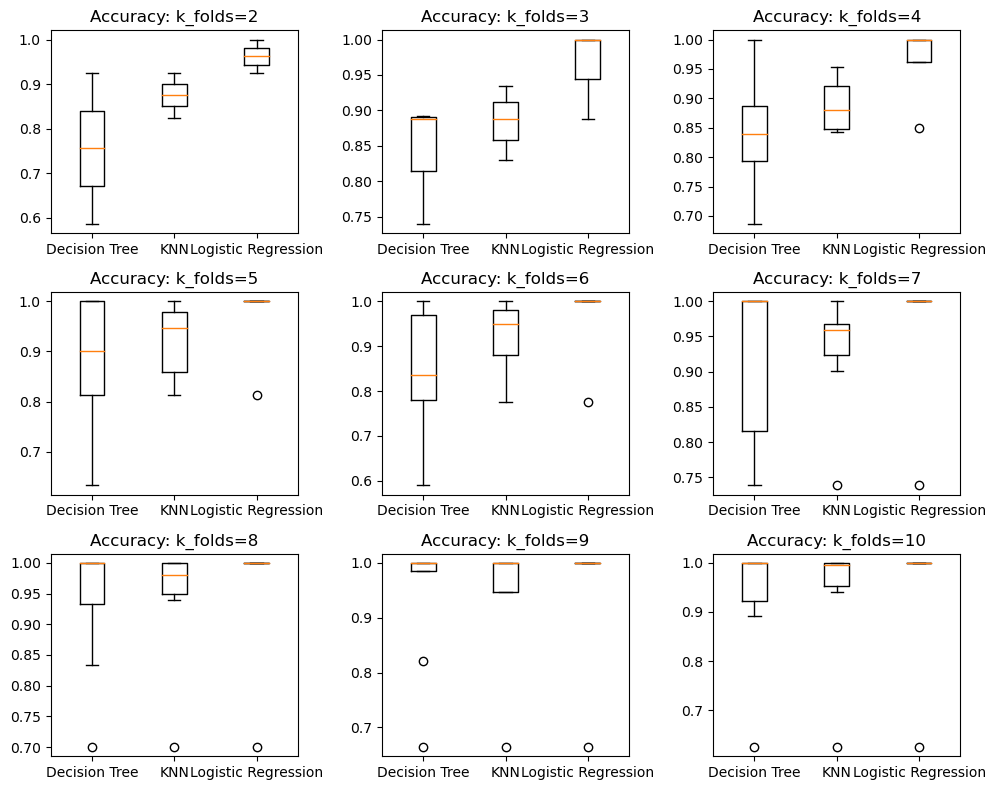

In [57]:
n_rows = 3
n_cols = 3

fix, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))

axes = axes.flatten()

for idx, k_folds in enumerate(range(2, 11)):
    dt_accuracy = cross_val_score(dt_model, Xs_enc, y, cv=k_folds, scoring="accuracy")
    knn_accuracy = cross_val_score(knn_model, Xs_enc, y, cv=k_folds, scoring="accuracy")
    lr_accuracy = cross_val_score(lr_model, Xs_enc, y, cv=k_folds, scoring="accuracy")
    models = ["Decision Tree", "KNN", "Logistic Regression"]
    scores = [dt_accuracy, knn_accuracy, lr_accuracy]

    axes[idx].boxplot(scores, labels=models)
    axes[idx].set_title(f"Accuracy: k_folds={k_folds}")

plt.tight_layout()
plt.show()

## AUC-ROC Chart

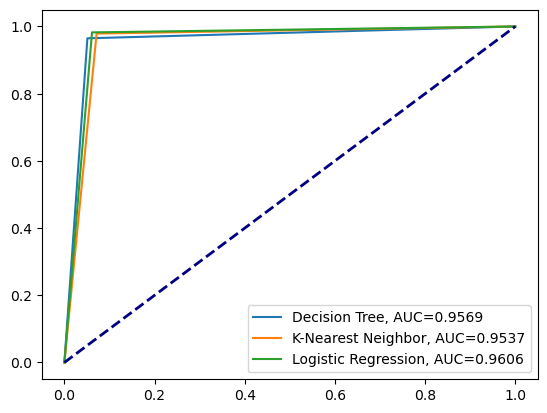

In [62]:
plt.figure()
jc.plot_roc(y_val, dty_pred, "Decision Tree")
jc.plot_roc(y_val, knny_pred, "K-Nearest Neighbor")
jc.plot_roc(y_val, lry_pred, "Logistic Regression")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

plt.xlabel = "False Positive Rate"
plt.ylabel = "True Positive Rate"
plt.legend(loc="lower right")
plt.show()

ValueError: Invalid color 1.0

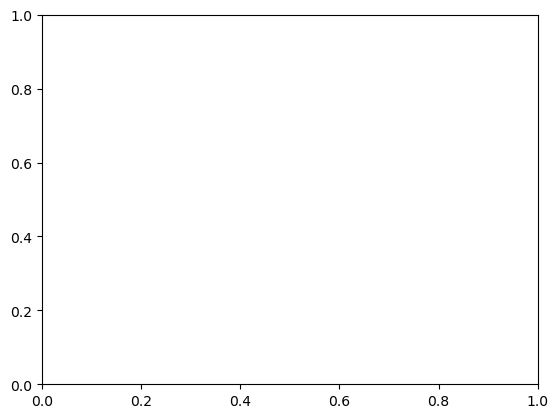

In [78]:
dt_proba = dt_model.predict_proba(X_val)[:, 1]
knn_proba = knn_model.predict_proba(Xs_val)[:, 1]
lr_proba = lr_model.predict_proba(Xs_val)[:, 1]
gainsChart(y_val, knn_proba)
plt.show()

In [74]:
plot_cumulative_gain(y_val, knn_proba)
plot_cumulative_gain(y_val, dt_proba)
plot_cumulative_gain(y_val, lr_proba)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed